Social media and mental health correlations. 

In this project, I will use preexisting data provided by a research project for the Statistics Course STA-2101 for the University of Liberal Arts Bangladesh (ULAB). Submitted to - Khan Raqib Mahmud. Submitted by - Souvik Ahmed (203014004) and Muhesena Nasiha Syeda (203014015).

In [35]:
#import libraries needed to run analysis and visualise the data
import pandas as pd 
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

Now that I've imported the libraries I need, I shall fetch the data and start pre processing the data.

In [36]:
#I've created a separate filepath.py function to record my directory. 
from filepath import filepath
#read the data - "filepath" should be replaced with the directory you store the smmh.csv file on your own device.
rawdata = pd.read_csv(filepath)
rawdata.head()

,Timestamp,1. What is your age?,2. Gender,3. Relationship Status,4. Occupation Status,5. What type of organizations are you affiliated with?,6. Do you use social media?,7. What social media platforms do you commonly use?,8. What is the average time you spend on social media every day?,9. How often do you find yourself using Social media without a specific purpose?,...,11. Do you feel restless if you haven't used Social media in a while?,"12. On a scale of 1 to 5, how easily distracted are you?","13. On a scale of 1 to 5, how much are you bothered by worries?",14. Do you find it difficult to concentrate on things?,"15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?","16. Following the previous question, how do you feel about these comparisons, generally speaking?",17. How often do you look to seek validation from features of social media?,18. How often do you feel depressed or down?,"19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?","20. On a scale of 1 to 5, how often do you face issues regarding sleep?"
0,4/18/2022 19:18:47,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,5,...,2,5,2,5,2,3,2,5,4,5
1,4/18/2022 19:19:28,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,4,...,2,4,5,4,5,1,1,5,4,5
2,4/18/2022 19:25:59,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,3,...,1,2,5,4,3,3,1,4,2,5
3,4/18/2022 19:29:43,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,4,...,1,3,5,3,5,1,2,4,3,2
4,4/18/2022 19:33:31,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,...,4,4,5,5,3,3,3,4,4,1


## Cleaning and Organising the data

Firstly, I don't need the timestamp data, so I'll remove that from the dataset. Then, to create an easy-to-use dataset, I would like to rename all the columns to workable titles and sort the question data into chronological order.

In [37]:
#deleting timestamp column 
notimedata = rawdata.drop(['Timestamp'], axis=1)

#rename the columns for useability. 
#Let's create a new data frame: 
newdata = pd.DataFrame(notimedata)
newdata.columns = ['Age', 'Gender', 'Relationship Status', 
                   'Occupation', 'Affiliations', 
                   'Use Social Media', 'Platforms Used', 'Time Spent', 
                   'Attention Q1', 'Attention Q2', 'Anxiety Q1', 
                   'Attention Q3', 'Anxiety Q2', 'Attention Q4', 
                   'Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3', 
                   'Depression Q1', 'Depression Q2', 'Depression Q3'
                   ]


#Checking that the titles are correct
newdata.head()
list(newdata.columns)

#Sorting the data so that the questions are in alphabetical and chronological order
#Create two data frames, one with demographic data (first object) and the other with questions that are sorted by column. 

data = pd.concat([newdata[['Age', 'Gender', 'Relationship Status', 
                   'Occupation', 'Affiliations', 
                   'Use Social Media', 'Platforms Used', 'Time Spent',]], 
                  newdata[['Attention Q1', 'Attention Q2', 'Anxiety Q1', 
                   'Attention Q3', 'Anxiety Q2', 'Attention Q4', 
                   'Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3', 
                   'Depression Q1', 'Depression Q2', 'Depression Q3']].sort_index(axis=1)], 
                 ignore_index=False,axis=1)
data.head()

#Just in case, manually check the first entry of the new df to the original raw data to ensure that the scores matched the original dataset. We're all good!

,Age,Sex,Relationship Status,Occupation,Affiliations,Use Social Media,Platforms Used,Time Spent,Anxiety Q1,Anxiety Q2,Attention Q1,Attention Q2,Attention Q3,Attention Q4,Depression Q1,Depression Q2,Depression Q3,Self Esteem Q1,Self Esteem Q2,Self Esteem Q3
0,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,2,2,5,3,5,5,5,4,5,2,3,2
1,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,2,5,4,3,4,4,5,4,5,5,1,1
2,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,1,5,3,2,2,4,4,2,5,3,3,1
3,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,1,5,4,2,3,3,4,3,2,5,1,2
4,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,4,5,3,5,4,5,4,4,1,3,3,3


### Checking for blank data

Looking for NaNs!

In [38]:
#Finding the rows and columns that have null values.
np.where(pd.isnull(data))

(array([ 17,  24,  42,  47,  63,  64,  74,  80,  85,  97, 108, 128, 162,
        166, 173, 194, 214, 219, 238, 251, 260, 322, 326, 364, 377, 399,
        425, 428, 453, 473]),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4]))

Looks like we have missing values in the 'Affiliations' column. 

Since the rest of the "Affiliations" data is a string, I'm going to replace all the NaNs with 'Unknown'

In [39]:
#Replace NaNs with "Unknown"
data = data.fillna('Unknown')
#Check that we don't have NaNs
np.where(pd.isnull(data))

(array([], dtype=int64), array([], dtype=int64))

## Checking the validity of responses

To make sure that the data shows participants that haven't created odd entries, let's check the responses for the fields that require manual input. Where 'Other' was selected, let's see what people have said. 

In [40]:
#What are the unique values in my dataset and are they super weird / to be excluded? 
for col in data: 
    print(data[col].unique())

[21.  22.  20.  24.  23.  25.  28.  34.  26.  35.  18.  19.  56.  65.
 17.  40.  33.  55.  27.  14.  38.  32.  30.  16.  48.  47.  50.  49.
 51.  46.  36.  37.  45.  42.  31.  69.  91.  15.  29.  43.  26.7 52.
 44.  60.  13.  53. ]
['Male' 'Female' 'Nonbinary ' 'Non-binary' 'NB' 'unsure ' 'Trans'
 'Non binary ' 'There are others???']
['In a relationship' 'Single' 'Married' 'Divorced']
['University Student' 'School Student' 'Salaried Worker' 'Retired']
['University' 'Private' 'Unknown' 'School, University' 'Company'
 'School, Private' 'University, Company' 'Goverment' 'Company, Private'
 'School' 'University, Goverment, Private' 'University, Company, Private'
 'University, Private' 'University, N/A' 'School, University, Private'
 'University, Goverment' 'University, Company, Goverment'
 'School, Company' 'School, N/A']
['Yes' 'No']
['Facebook, Twitter, Instagram, YouTube, Discord, Reddit'
 'Facebook, Instagram, YouTube, Pinterest' 'Facebook, Instagram'
 'Facebook, Instagram, YouTube'
 '

### Gender

Looks like we have two changes to make in the 'Gender' column: 
1. Exclude the participant data that gave the "There are others???" response
2. Change the names of Non-binary entries to have the same format: "Non-binary"

In [69]:
# Dropping the entry "There are others???" entry
data.drop(data.loc[data['Gender']=="There are others???"].index, inplace=True)

#Renaming the indices: Nonbinary, NB, Non binary
data['Gender'].replace(['Nonbinary ', 'NB', 'Non binary ', 'unsure ', 'Trans'], 
                    ['Other', 'Other', 'Other', 'Other', 'Other'], inplace=True)

#check that it worked
print(data['Gender'].unique())

['Male' 'Female' 'Non-binary' 'Other']


### Age

The 'Age' column is a float. So let's convert that.

In [42]:
#convert float to int
data['Age'] = data['Age'].astype(int)

#check
display(data['Age'].dtypes)

dtype('int64')

### Time Spent

I also want to make the time spent on social media more readable. 

In addition, I want to create a new column, Time Spent (mean), where the values are integers. That way, I can find out whether time spent and mental health scores correlate.


In [43]:
#Create more readable values
data['Time Spent'].replace(['Between 2 and 3 hours', 'More than 5 hours', 'Between 3 and 4 hours',
 'Less than an Hour', 'Between 1 and 2 hours', 'Between 4 and 5 hours'], ['2-3 hours', '>5 hours', '3-4 hours', '<1 hour', '1-2 hours', '4-5 hours'], inplace=True)

#check 
data['Time Spent'].unique()

#Create a column of time spent as an integer.
#Specify conditions for our new time values to be assigned.
conditions = [
    (data['Time Spent'] == '<1 hour'),
    (data['Time Spent'] == '1-2 hours'),
    (data['Time Spent'] == '2-3 hours'),
    (data['Time Spent'] == '3-4 hours'), 
    (data['Time Spent'] == '4-5 hours'), 
    (data['Time Spent'] == '>5 hours'), 
]
     
#Creating time values using the upper bounds of the range given (to avoid using 0 on the <1 values)
time_values = [1, 2, 3, 4, 5, 6]

#Create a new column for Time Spent with our new values for each categorical time slot.
data['Time (hrs)'] = np.select(conditions, time_values)
data.head()

#Check that no weird values have popped up
print(data['Time (hrs)'].unique())


[3 6 4 1 2 5]


## Mental Health Scoring

### Self esteem Question 2
Our assumption is that higher scores indicate negatively affected mental health. Self esteem question 2 works in reverse, where higher scores are associated with positive mental health. So, we need to convert this question so that the numbers, when summed to a total mental health score, accurately represent that a high score indicates negative effects on mental health. 

The default score is as follows: 
Very Negative - 1
Slightly Negative - 2
Neutral - 3 
Slightly Positive - 4
Very positive - 5


To create an accurate depiction of the effect of social media on mental health, including any positive effects, I will simply reverse the scoring, as seen below: 
Very Negative - 5
Slightly Negative - 4
Neutral - 3 
Slightly Positive - 2
Very positive - 1

In [44]:
#Create conditions again

selfesteem_conditions = [
    (data['Self Esteem Q2'] == 1), 
    (data['Self Esteem Q2'] == 2), 
    (data['Self Esteem Q2'] == 3), 
    (data['Self Esteem Q2'] == 4), 
    (data['Self Esteem Q2'] == 5)
]

new_esteem_values = [5, 4, 3, 2, 1]

#assign new values in the self esteem column
data['Self Esteem Q2'] = np.select(selfesteem_conditions, new_esteem_values)
data.head()

,Age,Sex,Relationship Status,Occupation,Affiliations,Use Social Media,Platforms Used,Time Spent,Anxiety Q1,Anxiety Q2,...,Attention Q2,Attention Q3,Attention Q4,Depression Q1,Depression Q2,Depression Q3,Self Esteem Q1,Self Esteem Q2,Self Esteem Q3,Time (hrs)
0,21,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",2-3 hours,2,2,...,3,5,5,5,4,5,2,3,2,3
1,21,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",>5 hours,2,5,...,3,4,4,5,4,5,5,5,1,6
2,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",3-4 hours,1,5,...,2,2,4,4,2,5,3,3,1,4
3,21,Female,Single,University Student,University,Yes,"Facebook, Instagram",>5 hours,1,5,...,2,3,3,4,3,2,5,5,2,6
4,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",2-3 hours,4,5,...,5,4,5,4,4,1,3,3,3,3


## Total Scores for Mental Health

To find out broadly how social media affects mental well being, let's get a total score from all the questionnaires. To dig deeper into potential interactions of mental health with each category (depression, attention, self-esteem), let's create new columns for these separate totals, too.

In [45]:
#Summing anxiety scores
data['Total Anxiety Score'] = data['Anxiety Q1'] + data['Anxiety Q2'] 

#Sum attention scores
data['Total Attention Score'] = data['Attention Q1'] + data['Attention Q2'] + data['Attention Q3'] + data['Attention Q4']

#Sum Depression Scores 
data['Total Depression Score'] = data['Depression Q1'] + data['Depression Q2'] + data['Depression Q3']

#Sum Self Esteem Scores 
data['Total Self Esteem Score'] = data['Self Esteem Q1'] + data['Self Esteem Q2'] + data['Self Esteem Q3']

#Total mental health score 
data['Total Score'] = data['Total Self Esteem Score'] + data['Total Depression Score'] + data['Total Attention Score'] + data['Total Anxiety Score']

#See the scores
data.head()

,Age,Sex,Relationship Status,Occupation,Affiliations,Use Social Media,Platforms Used,Time Spent,Anxiety Q1,Anxiety Q2,...,Depression Q3,Self Esteem Q1,Self Esteem Q2,Self Esteem Q3,Time (hrs),Total Anxiety Score,Total Attention Score,Total Depression Score,Total Self Esteem Score,Total Score
0,21,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",2-3 hours,2,2,...,5,2,3,2,3,4,18,14,7,43
1,21,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",>5 hours,2,5,...,5,5,5,1,6,7,15,14,11,47
2,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",3-4 hours,1,5,...,5,3,3,1,4,6,11,11,7,35
3,21,Female,Single,University Student,University,Yes,"Facebook, Instagram",>5 hours,1,5,...,2,5,5,2,6,6,12,9,12,39
4,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",2-3 hours,4,5,...,1,3,3,3,3,9,17,9,9,44


# Data Visualisation Babaaay! 

We did it. Cleaned and transformed the data. Now, for the real stuff.

In this section, let's explore some research questions: 
1. How does the time spent on social media affect mental health scores? 
2. How does social media usage and mental health scores differ across demographic groups? 

## How does time spent on social media affect mental health scores?

First, visualising our data before testing for relationships, starting with how much time our participants spend on social media. 

/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


0.9073861837387085

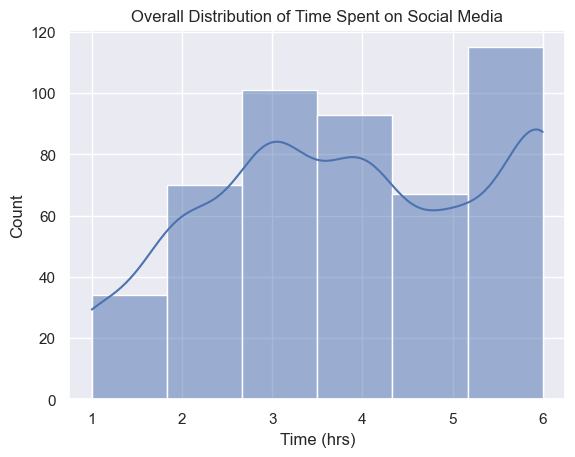

In [46]:
#Set the theme and make stuff look good
sns.set_theme()

#Are the scores normally distributed? Starting with Time spent on social media:
sns.histplot(data=data, x=data['Time (hrs)'], bins=6, kde=True).set(
    title='Overall Distribution of Time Spent on Social Media')

#Shapiro wilkes test just to make sure:
res = stats.shapiro(data['Time (hrs)'])
res.statistic #gives high value, indicating it's normally distributed.

We can say that our sample generally spends more than 1 hour on social media per day.

## Distribution of total mental health scores

Next up, let's see how the mental health scores are distributed in our sample of total participants.

/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Overall Distribution of Total Mental Scores')]

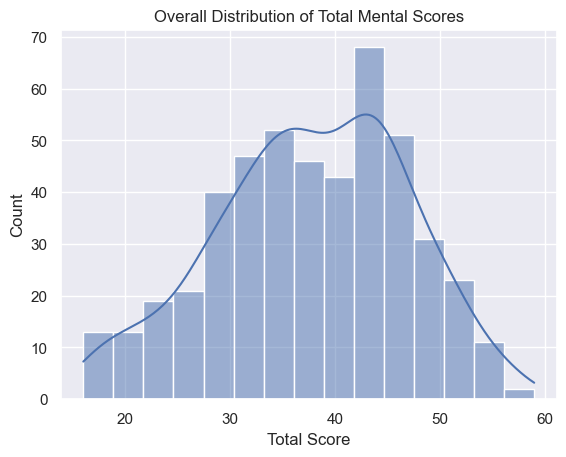

In [47]:
#Now, mental health scores:
sns.histplot(data=data, x=data['Total Score'], kde=True).set(
    title='Overall Distribution of Total Mental Scores') #graph looks normal.

## Is there a relationship between mental health scores and time spent on social media? 

Now that we know that our data is normally distributed, we can visualise whether a relationship exists between time spent on social media and mental health scores.

/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Relationship Between Social Media Usage and Mental Health Scores')]

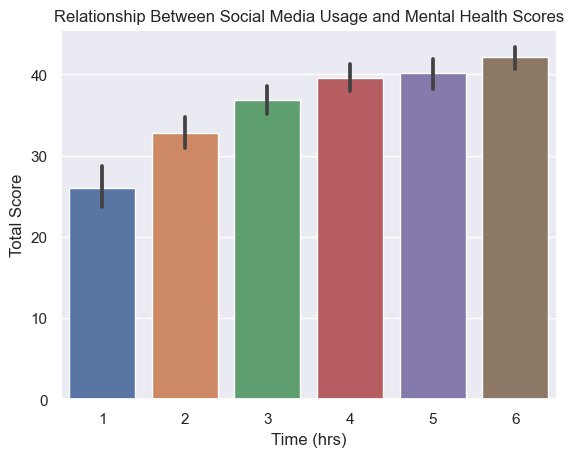

In [48]:
#Plot time spent on social media versus mental health scores
sns.barplot(
    data=data, x=data['Time (hrs)'], y=data['Total Score']).set(
        title='Relationship Between Social Media Usage and Mental Health Scores')

From the bar plot, it looks like there's a positive, linear relationship between time spent on social media and mental health scores. Pearson's correlation coefficient can assist with testing this hypothesis.

In [49]:
#Using Pearson's Coefficient to determine whether this really is a linear relationship
pcoeff = stats.pearsonr(data['Time (hrs)'], data['Total Score'])
pcoeff.statistic #test statistic indicates a positive, linear relationship (r=0.45)

0.4527834010484766

So there's a positive correlation between social media usage (in hours) and mental health scores. This is incredibly general though. We're not sure which attributes of the participants are related to mental health scores.

## Mental Health Scores by Demographic
Let's start with age.

/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


1.8602765333270305e-27

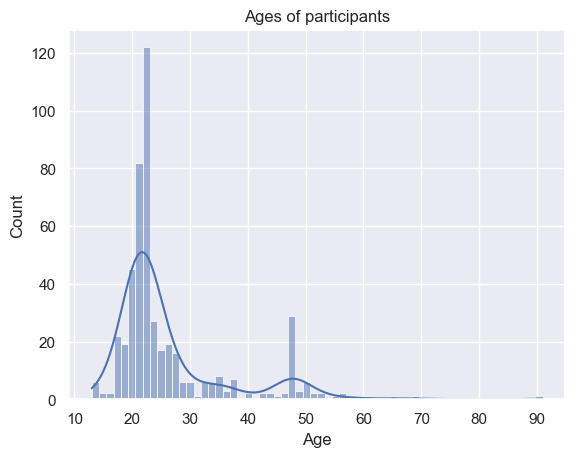

In [50]:
sns.histplot(data=data, x=data['Age'], kde=True).set(
    title='Ages of participants')

res = stats.shapiro(data['Age'])
res.pvalue

Age x Mental health

/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandragilbert/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Age', ylabel='Total Score'>

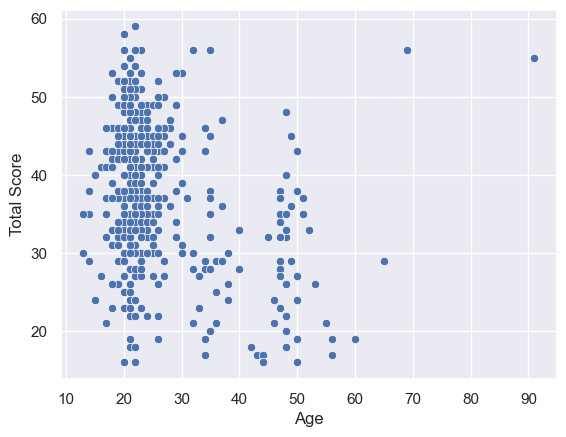

In [51]:
sns.scatterplot(data=data, x=data['Age'], y=data['Total Score'])

Gender x Mental health

Text(0.5, 1.0, 'Gender Distribution')

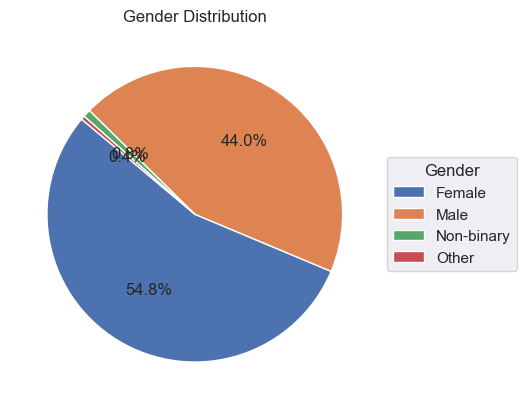

In [68]:
#pie chart of gender distribution
gender_counts = data['Gender'].value_counts()
plt.pie(gender_counts, autopct='%1.1f%%', startangle=140)
plt.legend(gender_counts.index, title="Gender", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Gender Distribution")

In [ ]:
sns.scatterplot(data=data, x=data['Age'], y=data['Total Score'])